In [4]:
import os, sys
import django
PROJECTPATH = '/opt/compute_node/'
sys.path.insert(0, PROJECTPATH)
os.environ.setdefault("REDIS_HOST", "redis_int")
os.environ.setdefault("REDIS_PORT", "6379")
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "compute_node.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"  # https://docs.djangoproject.com/en/4.1/topics/async/#async-safety
os.chdir(PROJECTPATH)
django.setup()

In [2]:
from analysis.models import Material
from sporian.models import Scan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
materials = Material.objects.all()

In [4]:
from analysis.models import Siamese

# Select Siamese model here with PK
s = Siamese.objects.get(pk=10)
# s = Siamese.objects.get(pk=11)

In [24]:
from analysis.util import normalize

def get_reflectance(scanNum):
    print(f"Getting reflectance at: {scanNum}")
    scan_set = Scan.objects.filter(scanNum__lt=scanNum).order_by('-scanNum')[:1000]
    return np.max(
        np.array([
            scan.vis_data
            for scan in scan_set
        ]), axis=0
    )

def yield_batch(queryset, batch_size=10):
    total_samples = queryset.count()
    start_index = 0
    while start_index < total_samples:
        batch_samples = queryset[start_index:start_index+batch_size]
        yield batch_samples
        start_index += batch_size

df = []
for idx, material in enumerate(materials):
    print(f"Loading material: {material}")
    scan_samples = material.scans.order_by("scanNum")
    for idx2, batch in enumerate(
            yield_batch(
                scan_samples, 
                batch_size=max(10, int(scan_samples.count()/10))
            )
        ):
        if s.dynamic_scale:
            reflectance = get_reflectance(batch[0].scanNum)
            vis_data = normalize([
                scan.vis_data
                for scan in batch
            ], reflectance=reflectance)
        else:
            vis_data = normalize([
                scan.vis_data
                for scan in batch
            ])
        vis_data = np.median(vis_data, axis=0)
        df.append({"label": material.material_id, "signal": vis_data})

df = pd.DataFrame(df)
df

Loading material: fence [3803028704 - 3803044363]
Getting reflectance at: 3803028709
Getting reflectance at: 3803029177
Getting reflectance at: 3803030990
Getting reflectance at: 3803033175
Getting reflectance at: 3803033645
Getting reflectance at: 3803035841
Getting reflectance at: 3803037662
Getting reflectance at: 3803039877
Getting reflectance at: 3803040337
Getting reflectance at: 3803042533
Getting reflectance at: 3803044343
Loading material: piglet [3803027073 - 3803042735]
Getting reflectance at: 3803027078
Getting reflectance at: 3803028591
Getting reflectance at: 3803030784
Getting reflectance at: 3803031576
Getting reflectance at: 3803033762
Getting reflectance at: 3803035257
Getting reflectance at: 3803036036
Getting reflectance at: 3803038228
Getting reflectance at: 3803039717
Getting reflectance at: 3803041924
Getting reflectance at: 3803042715
Loading material: piglet [3803013003 - 3803026302]
Getting reflectance at: 3803013711
Getting reflectance at: 3803015171
Getting 

KeyboardInterrupt: 

Getting reflectance at: 3803028591


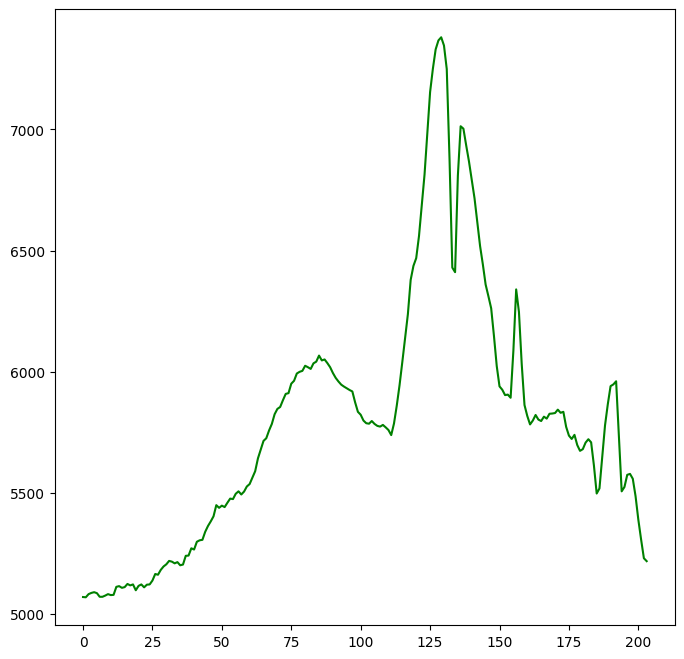

In [25]:
fig = plt.figure(figsize=(8, 8))
plt.plot(get_reflectance(3803028591), color='g')
plt.show()

In [6]:
g = df.groupby('label')
print("Sample distribution by label")
print(g.size())

sample_count = g.size().min()
if sample_count < (g.size().mean()/2):
    print(f"WARNING: Under represented class in dataset ({sample_count} samples) - advise increasing data samples in dataset!")    

Sample distribution by label
label
cow             32
fence           11
goat            32
hog             22
horse           11
panelblue       22
piglet          22
plasticpanel    22
plywood         11
vegetation      21
dtype: int64


In [7]:
target_samples = 100

print(f"Resampling dataset to {target_samples} samples for each class")
sdf = g.apply(lambda x: x.sample(target_samples, replace=True))
sdf = sdf.reset_index(drop=True)

Resampling dataset to 100 samples for each class


In [8]:
sdf

label                                             signal
0           cow  [1.3930345, 1.388267, 1.3567485, 1.373006, 1.4...
1           cow  [1.2176969, 1.2119291, 1.3347766, 1.2020289, 1...
2           cow  [1.0877796, 1.0760446, 1.1325936, 1.1231501, 1...
3           cow  [1.1319227, 1.0974061, 1.1058681, 1.116143, 1....
4           cow  [1.1612816, 1.1425663, 1.134288, 1.1853931, 1....
..          ...                                                ...
995  vegetation  [1.0575476, 1.054312, 1.054831, 1.0593872, 1.0...
996  vegetation  [1.1738635, 1.1422576, 1.1850623, 1.1801021, 1...
997  vegetation  [1.0519562, 1.0512289, 1.0478957, 1.0559065, 1...
998  vegetation  [1.0560048, 1.0609324, 1.0514331, 1.0696573, 1...
999  vegetation  [1.1679184, 1.1845825, 1.2094473, 1.1837981, 1...

[1000 rows x 2 columns]

In [9]:
def normalize_vis(signal, reflectance=None):
    signal = signal.astype('float32')
    if reflectance is not None:
        signal /= reflectance
    signal = signal - signal.mean(axis=1)[:,np.newaxis]
    signal /= signal.std(axis=1)[:,np.newaxis]
    return signal

Label cow - samples: 100


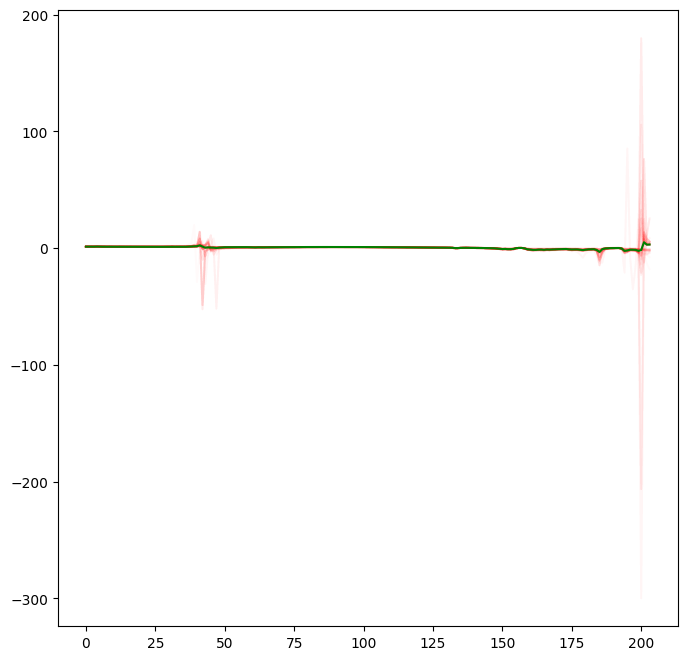

Label fence - samples: 100


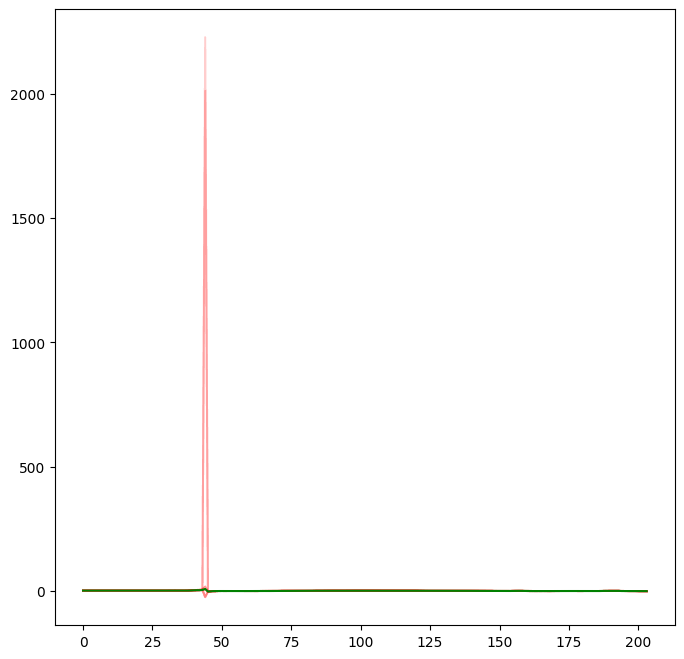

Label goat - samples: 100


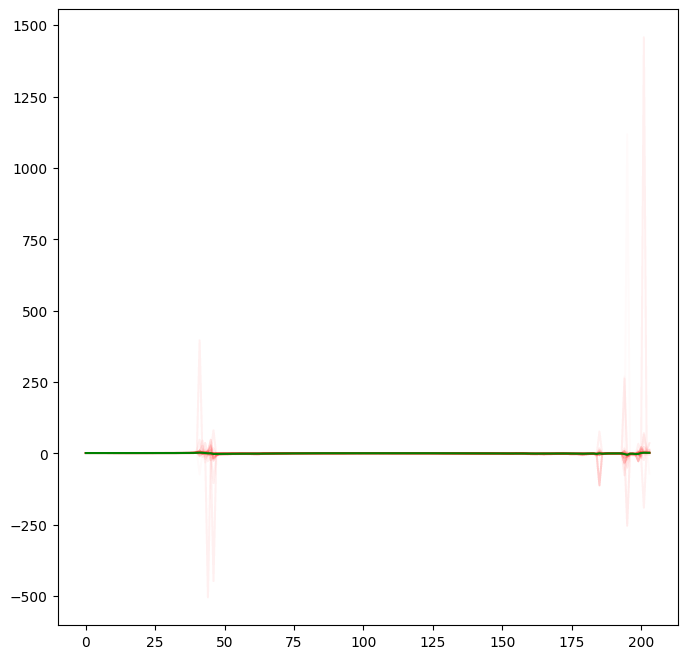

Label hog - samples: 100


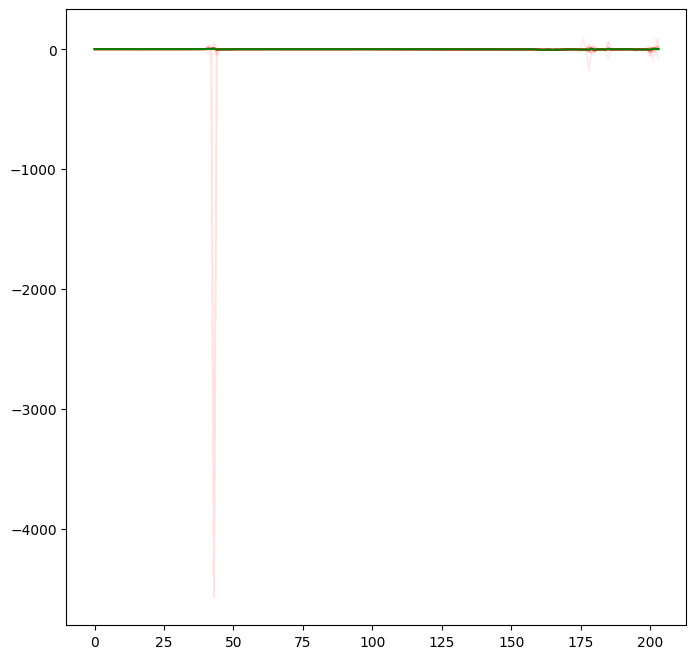

Label horse - samples: 100


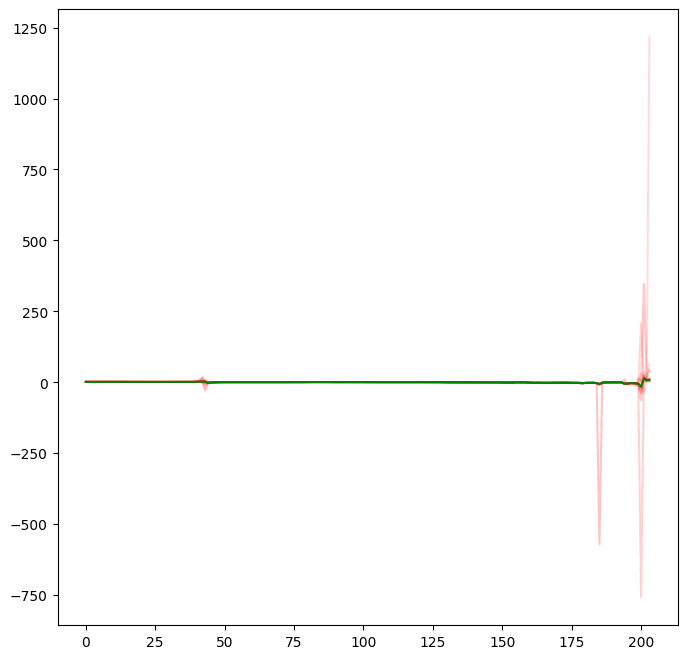

Label panelblue - samples: 100


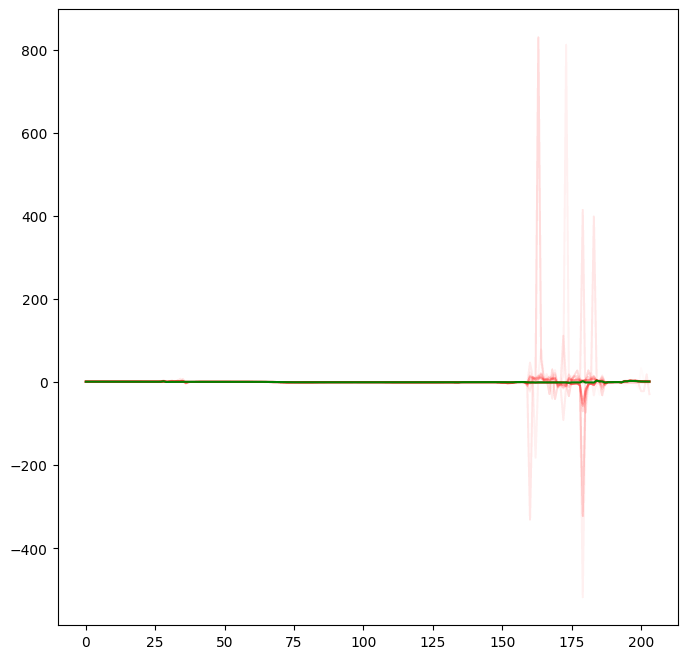

Label piglet - samples: 100


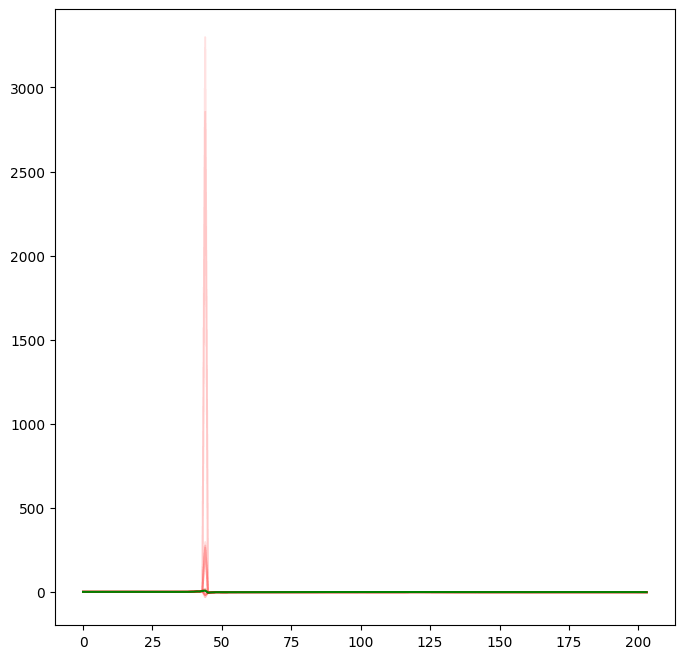

Label plasticpanel - samples: 100


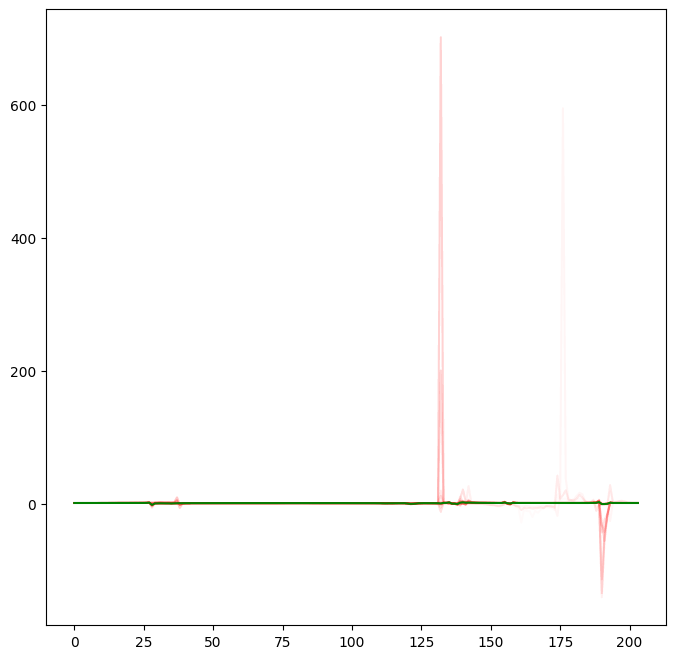

Label plywood - samples: 100


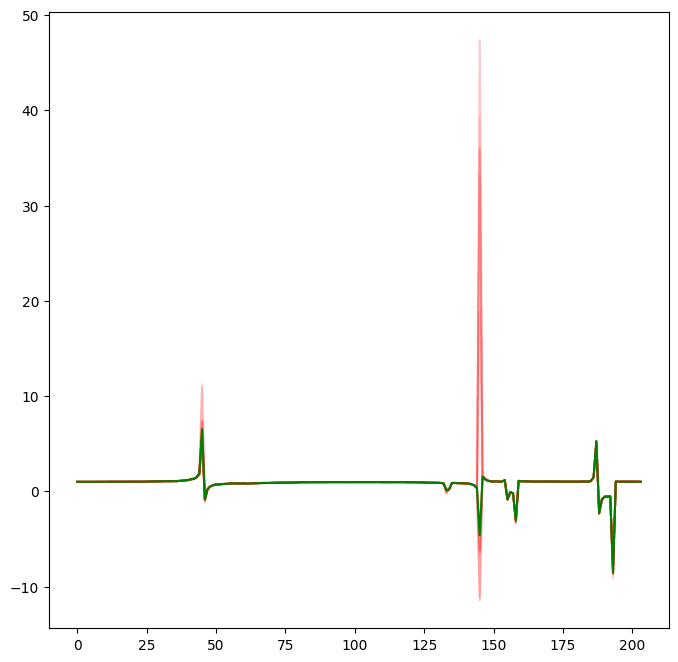

Label vegetation - samples: 100


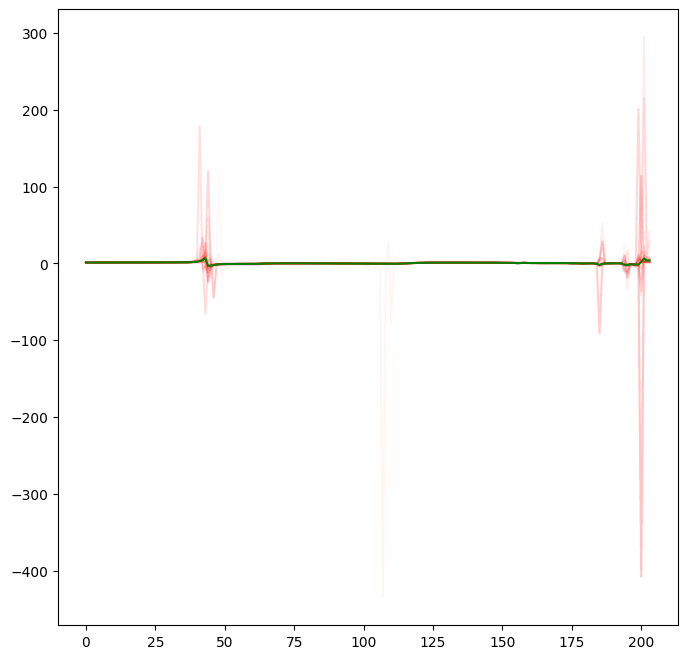

In [10]:
training_data = {}
for label, ldf in sdf.groupby('label'):
    vis = np.array(ldf['signal'].to_list())
    training_data[label] = {
        'vis_data': vis
    }
    
for label, label_data in training_data.items():
    print(f"Label {label} - samples: {len(label_data['vis_data'])}")    
    fig = plt.figure(figsize=(8, 8))
    for v in label_data['vis_data']:
        plt.plot(v, color='r', alpha=0.02)
    plt.plot(np.median(label_data['vis_data'], axis=0), color='g')
    plt.show()

In [11]:
import random
from sklearn.model_selection import train_test_split

def create_training_dataset(tdata_dict, background=None, undersample_nonmatch_rate=1):
    """
    Creates a mixture of data where the target is 1 (found), or 0 (not found)
    Uses the labels in tdata_dict to make true positive matches, and true negatives
    """
    data, target = [], []
    
    for rlabel, label_data in tdata_dict.items():
        if rlabel == background:
            continue # Don't train on a reference signal for background - nonsense
        print(f"Inserting data for {rlabel}")
        
        for tlabel, tlabel_data in tdata_dict.items():
            ref_signal = label_data['vis_data'][random.randint(0, len(label_data['vis_data']) - 1)]
            ref_match = 1.0 if tlabel == rlabel else 0.0
            training_sigs = tlabel_data['vis_data']
            if tlabel != rlabel:
                training_sigs = training_sigs[::undersample_nonmatch_rate]
            print(f"\tSampling from {tlabel} - target={ref_match} num_samples={len(training_sigs)}")
            # Data consists of Reference (left) and sensor signal (right)                
            for train_sig in training_sigs:
                data.append([ref_signal, train_sig])
                target.append(ref_match) # Distance
    return np.array(data).astype(np.float16), np.array(target)

train_data, train_target = create_training_dataset(training_data, undersample_nonmatch_rate=1)

X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_target,
    test_size=0.25, random_state=42, shuffle=True
)

print(X_train.shape, X_train.dtype)

Inserting data for cow
	Sampling from cow - target=1.0 num_samples=100
	Sampling from fence - target=0.0 num_samples=100
	Sampling from goat - target=0.0 num_samples=100
	Sampling from hog - target=0.0 num_samples=100
	Sampling from horse - target=0.0 num_samples=100
	Sampling from panelblue - target=0.0 num_samples=100
	Sampling from piglet - target=0.0 num_samples=100
	Sampling from plasticpanel - target=0.0 num_samples=100
	Sampling from plywood - target=0.0 num_samples=100
	Sampling from vegetation - target=0.0 num_samples=100
Inserting data for fence
	Sampling from cow - target=0.0 num_samples=100
	Sampling from fence - target=1.0 num_samples=100
	Sampling from goat - target=0.0 num_samples=100
	Sampling from hog - target=0.0 num_samples=100
	Sampling from horse - target=0.0 num_samples=100
	Sampling from panelblue - target=0.0 num_samples=100
	Sampling from piglet - target=0.0 num_samples=100
	Sampling from plasticpanel - target=0.0 num_samples=100
	Sampling from plywood - target

In [12]:
train_data.shape

(10000, 2, 204)

In [13]:
from tensorflow.keras import Input, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import pickle, os
from sklearn.metrics import confusion_matrix  


def create_input_layers(xshapes):
    inputs = []
    for xshape in xshapes:
#         input_shape_x = (xshape[1], 1)
        input_shape_x = (xshape[1]) # For 1D variant
        input_x = Input(shape = input_shape_x)
        inputs.append(input_x)
    return inputs


def create_convolution_layers(inputs, num_layers = 0):
    convs = []
    for input_x in inputs:
        input_x = layers.Reshape(target_shape=(input_x.shape[1],1))(input_x) # For 1D variant
        conv      = layers.Conv1D(32,  5,  activation='relu', input_shape=input_x.get_shape())(input_x)
        conv      = layers.MaxPooling1D(strides=2, padding='valid')(conv)
        conv      = layers.Dropout(0.25)(conv)
        for i in range(num_layers):
            conv      = layers.Conv1D(32,  5,  activation='relu')(conv)
            conv      = layers.MaxPooling1D(strides=2, padding='valid')(conv)
            conv      = layers.Dropout(0.25)(conv)
        convs.append(conv)
    return convs


def contrast_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = (y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss


def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)


def pSCNN(xshapes, num_conv_layers):
    inputs = create_input_layers(xshapes)
    convs = create_convolution_layers(inputs, num_layers = num_conv_layers)
    if len(convs) >= 2:
        conv_merge = layers.concatenate(convs)
    else:
        conv_merge = convs[0]
    flat      = layers.Flatten()(conv_merge)
    dense     = layers.Dense(100,  activation='relu')(flat)
    dense     = layers.Dropout(0.2)(dense)
    output    = layers.Dense(1, activation='sigmoid')(dense)
    model     = models.Model(inputs= inputs, outputs=output)
    
    model.compile(
#         optimizer=optimizers.Adam(learning_rate=0.00001), 
        optimizer=optimizers.RMSprop(),
        loss=contrast_loss,
#         loss='binary_crossentropy', 
          metrics=[acc]
    )
    return model

In [14]:
X_train.shape

(7500, 2, 204)

In [15]:
training_data[list(training_data.keys())[0]]['vis_data']

array([[  1.3930345,   1.388267 ,   1.3567485, ...,  -1.3555695,
         -1.8609558,  -1.8622588],
       [  1.2176969,   1.2119291,   1.3347766, ...,   7.2624936,
          3.219659 ,   3.1494184],
       [  1.0877796,   1.0760446,   1.1325936, ...,   3.9935398,
          2.7313695,   2.6872334],
       ...,
       [  1.3951735,   1.373762 ,   1.3880501, ...,  -1.8316534,
         -2.771246 ,  -2.463912 ],
       [  1.247798 ,   1.1943104,   1.2554071, ..., -12.533663 ,
         11.026504 ,  25.402954 ],
       [  1.4028273,   1.3930708,   1.4017596, ...,  76.39513  ,
          3.6562932,   3.8529255]], dtype=float32)

In [16]:
sample_ref = training_data[list(training_data.keys())[0]]['vis_data']
sporian_model = pSCNN([[None, sample_ref.shape[1]], [None, sample_ref.shape[1]]], 2)

2024-04-24 19:41:01.285171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2024-04-24 19:41:01.285247: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-24 19:41:01.285270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a5b23ce38b6d): /proc/driver/nvidia/version does not exist
2024-04-24 19:41:01.285563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
sample_ref

array([[  1.3930345,   1.388267 ,   1.3567485, ...,  -1.3555695,
         -1.8609558,  -1.8622588],
       [  1.2176969,   1.2119291,   1.3347766, ...,   7.2624936,
          3.219659 ,   3.1494184],
       [  1.0877796,   1.0760446,   1.1325936, ...,   3.9935398,
          2.7313695,   2.6872334],
       ...,
       [  1.3951735,   1.373762 ,   1.3880501, ...,  -1.8316534,
         -2.771246 ,  -2.463912 ],
       [  1.247798 ,   1.1943104,   1.2554071, ..., -12.533663 ,
         11.026504 ,  25.402954 ],
       [  1.4028273,   1.3930708,   1.4017596, ...,  76.39513  ,
          3.6562932,   3.8529255]], dtype=float32)

In [18]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.config.experimental_run_functions_eagerly(True)

2024-04-24 19:41:01,433 WARNING[tensorflow.new_func:350]From /tmp/ipykernel_76/2412517725.py:3: experimental_run_functions_eagerly (from tensorflow.python.eager.def_function) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

history = sporian_model.fit(
    x=[X_train[:,0,:], X_train[:,1,:]],
    y=y_train,
    batch_size=200, callbacks=[callback],
    epochs=500,
    validation_data=([X_test[:,0,:], X_test[:,1,:]], y_test),
#     class_weight={0:1, 1:len(training_data.keys())}
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/500
38/38 [==============================] - 6s 146ms/step - loss: 0.1051 - acc: 0.8889 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2/500
38/38 [==============================] - 5s 142ms/step - loss: 0.0803 - acc: 0.9081 - val_loss: 0.0722 - val_acc: 0.9196
Epoch 3/500
38/38 [==============================] - 5s 141ms/step - loss: 0.0589 - acc: 0.9293 - val_loss: 0.0433 - val_acc: 0.9476
Epoch 4/500
38/38 [==============================] - 5s 142ms/step - loss: 0.0467 - acc: 0.9452 - val_loss: 0.0352 - val_acc: 0.9620
Epoch 5/500
38/38 [==============================] - 5s 141ms/step - loss: 0.0368 - acc: 0.9567 - val_loss: 0.0278 - val_acc: 0.9740
Epoch 6/500
38/38 [==============================] - 5s 141ms/step - loss: 0.0306 - acc: 0.9664 - val_loss: 0.0218 - val_acc: 0.9812
Epoch 7/500
38/38 [==============================] - 5s 142ms/step - loss: 0.0277 - acc: 0.9704 - val_loss: 0.0194 - val_acc: 0.9820
Epoch 8/500
38/38 [==============================] - 5s 141ms/step - 

In [20]:
sporian_model.save(s.model_path)

2024-04-24 19:46:04,440 WARNING[absl.__init__:233]Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.
2024-04-24 19:46:04,859 INFO[tensorflow.copy_assets_to_destination_dir:779]Assets written to: /data/model_Siamese_11/assets


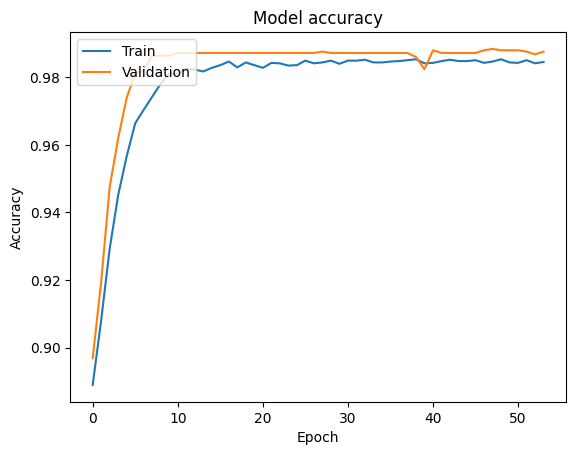

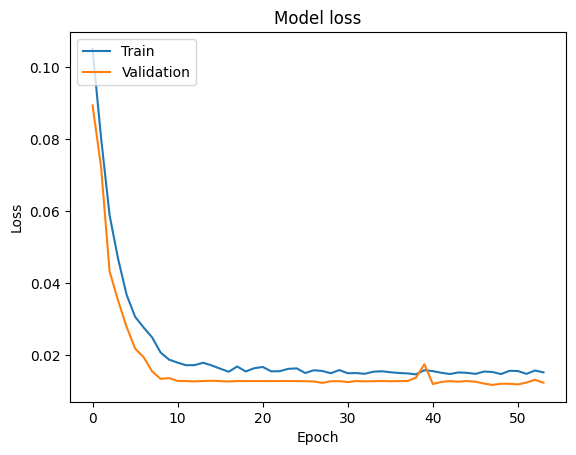

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming 'history' is the training history object returned by model.fit()
plot_training_history(history)

In [ ]:
def contrast_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = (y * squaredPreds + (1 - y) * squaredMargin)
    return loss


sporian_model = tf.keras.models.load_model(
    "./analysis/models/siamese.model", 
    custom_objects={"contrast_loss": contrast_loss},
)

In [31]:
test = np.arange(40).reshape((5,-1))
print(test.shape)
test

(5, 8)


array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39]])

In [17]:
np.repeat(test, 4, axis=0)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [32, 33, 34, 35, 36, 37, 38, 39]])

In [13]:
preds = np.arange(20)
preds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [32]:
reshaped_array = np.array(np.split(preds, test.shape[0], axis=0))
print(reshaped_array.shape)

(5, 4)


In [26]:
df = pd.DataFrame(
    1 + (reshaped_array * -1),
    columns=[f"similarity.{l}" for l in range(4)]
)
df

similarity.0  similarity.1  similarity.2  similarity.3
0             1             0            -1            -2
1            -3            -4            -5            -6
2            -7            -8            -9           -10
3           -11           -12           -13           -14
4           -15           -16           -17           -18

In [29]:
df.head()

similarity.0  similarity.1  similarity.2  similarity.3
0             1             0            -1            -2
1            -3            -4            -5            -6
2            -7            -8            -9           -10
3           -11           -12           -13           -14
4           -15           -16           -17           -18

In [30]:
df.idxmax(axis="columns")

0    similarity.0
1    similarity.0
2    similarity.0
3    similarity.0
4    similarity.0
dtype: object